author: spe

This script shows examples about how to solve for the dynamics of a 1D MOT and
calculate things like 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy.constants as cts
import pylcp
import pylcp.atom as atom

#plt.style.use('paper')

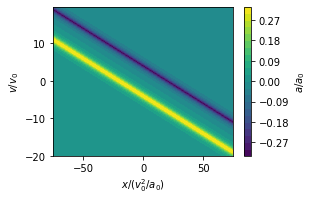

In [2]:
def dimForce(x, v, delta, beta, alpha, totbeta):
    return beta(x)*\
               (1/(1 + totbeta(x) + 4*(delta - v - alpha*x)**2) - \
                1/(1 + totbeta(x) + 4*(delta + v + alpha*x)**2) )

x = np.arange(-75, 75, 0.4)
v = np.arange(-20, 20, 0.2)

X, V = np.meshgrid(x,v)

det = -4.0
alpha = 0.2
beta = 1.0
nb = 2.0

F = dimForce(X,V,det,lambda x: beta, alpha, lambda x: nb*beta)

plt.figure(1,figsize=(4,2.75))
plt.clf()
plt.contourf(X,V,F,25)
cb1 = plt.colorbar()
cb1.set_label('$a/a_0$')
plt.xlabel('$x/(v_0^2/a_0)$')
plt.ylabel('$v/v_0$')
plt.subplots_adjust(left=0.12,right=0.9)

Now, let's see if we can solve the dynamics in several different ways:

In [3]:
def atom_motion_dt(y, t, delta, beta, alpha, totalbeta, numofbeams):
    pos, vel = y
    accel = dimForce(pos, vel, delta, beta, alpha, totalbeta, numofbeams)
    return np.array([vel, accel])

def atom_motion_dx(v, x, delta, beta, alpha, totalbeta, numofbeams):
    accel = dimForce(x, v, delta, beta, alpha, totalbeta, numofbeams)
    return accel/v

Let's start by coming in at different locations in phase space:

In [4]:
v0s = np.arange(1,50,1)
x0s = x[0]*np.ones(v0s.shape)
#x0s = -v0s/alpha
t = np.arange(0,1000,0.01)
    
for ii in range(v0s.size):
    sol = odeint(atom_motion_dt, [x0s[ii], v0s[ii]], t,
                 args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))
    
    plt.figure(1)
    plt.plot(sol[:,0],sol[:,1],'w--',linewidth=0.25)
    
for ii in range(v0s.size):
    sol = odeint(atom_motion_dt, [-x0s[ii], -v0s[ii]], t,
                 args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))
    
    plt.figure(1)
    plt.plot(sol[:,0],sol[:,1],'w--',linewidth=0.25)

TypeError: dimForce() takes 6 positional arguments but 7 were given

Let's also start at max(x) and v=0 and integrate the equations backwards from 
that point and forward from that point.  By starting at this point, the atom 
should be the maximal atom that is captured

In [5]:
tneg = np.arange(0,-1000,-0.01)
tpos = np.arange(0,1000,0.01)

sol_neg = odeint(atom_motion_dt, [x[-1], 0], tneg, 
                 args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))
sol_pos = odeint(atom_motion_dt, [x[-1], 0], tpos, 
                 args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))

TypeError: dimForce() takes 6 positional arguments but 7 were given

Plot up the result in phase space:

In [6]:
plt.figure(1)
plt.plot(sol_neg[:,0],sol_neg[:,1],'w-',linewidth=1)
plt.plot(sol_pos[:,0],sol_pos[:,1],'w-',linewidth=1)
plt.xlim((-np.amax(x),np.amax(x)))
plt.ylim((-np.amax(v),np.amax(v)))

NameError: name 'sol_neg' is not defined

<Figure size 432x288 with 0 Axes>

Plot up the result vs time:

NameError: name 'sol_neg' is not defined

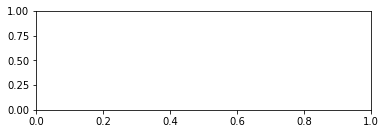

In [7]:
plt.figure(2)
plt.clf()
plt.subplot('211')
plt.plot(tneg,sol_neg[:,0],tpos,sol_pos[:,0])
plt.subplot('212')
plt.plot(tneg,sol_neg[:,1],tpos,sol_pos[:,1])

Finally, let's integrate to find v(x), rather than v(t) and x(t).  Let's do 
this with the same starting point: max(x) and v=0.  However, because of a 
divergence problem, we must start with a negligibly small velocity: 

In [8]:
xint = np.arange(x[-1],x[0],-0.05)
sol_dvdx = odeint(atom_motion_dx, 1e-9, xint,
                  args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))

plt.figure(1)
plt.plot(xint,sol_dvdx,'--',linewidth=1,color=(0.75,0.75,0.75))
plt.xlim((-np.amax(x),np.amax(x)))
plt.ylim((-np.amax(v),np.amax(v)))

TypeError: dimForce() takes 6 positional arguments but 7 were given

Run the beam size calculation:

In [9]:
xc = np.logspace(-1,3,41)

X,V = np.meshgrid(np.linspace(-xc[-1],xc[-1],1000),v)
alpha = 0.426 # alpha for Rb
# alpha = 0.071 #alpha for Li
beta = 1.0
det = -1.0

ve = np.zeros(xc.shape)
vc = np.zeros(xc.shape)

vp, v0 =  lcp.universaldvdxcurve(alpha,beta,det,nb)

plt.figure(3,figsize=(4,2.75))
plt.clf()
plt.contourf(X,V,dimForce(X,V,det,lambda x: beta,alpha,lambda x: nb*beta, nb),25)
cb1 = plt.colorbar()
cb1.set_label('$a/a_0$')
plt.xlabel('$x/(v_0^2/a_0)$')
plt.ylabel('$v/v_0$')
plt.subplots_adjust(left=0.12,right=0.9)

for ii in range(ve.size):   
    xint = np.arange(xc[ii],-xc[ii],-np.amin([xc[ii]/1000.0,0.05]))
    sol_dvdx = odeint(atom_motion_dx, 1e-9, xint, 
                      args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))
    
    ve[ii] = np.interp(np.array([0.0]),xint[::-1],sol_dvdx.flatten()[::-1])
    vc[ii] = sol_dvdx[-1]
    
    plt.plot(xint,sol_dvdx,'--',linewidth=1,color=(0.75,0.75,0.75))

NameError: name 'lcp' is not defined

Because the final points here are so weird, let's check just the last one 
by integrating the time equations again:

In [10]:
tneg = np.arange(0,-100000,-0.01)
tpos = np.arange(0,100000,0.01)
sol_neg = odeint(atom_motion_dt, [xc[-1], 0], tneg, 
                 args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))
sol_pos = odeint(atom_motion_dt, [xc[-1], 0], tpos, 
                 args=(det,lambda x: beta,alpha,lambda x: nb*beta, nb))
plt.plot(sol_neg[:,0],sol_neg[:,1],'w-',linewidth=1)
plt.plot(sol_pos[:,0],sol_pos[:,1],'w-',linewidth=1)
plt.plot(xint,xint*vp+v0,'w-.',linewidth=0.5)
plt.xlim((-xc[-1],xc[-1]))
plt.ylim((v[0],v[-1]))

TypeError: dimForce() takes 6 positional arguments but 7 were given

Now, try to solve the problem in the small beam limit with the  little 
theory I worked out:

In [12]:
def smallBeamVcVeprop(alpha,beta,delta,nb):
    f1 = 16*nb*beta*delta/(1+nb*beta+4*delta**2)**2
    
    if np.abs(f1)>4*alpha:
        gammap = -f1/2 + np.sqrt(f1**2+4*f1*alpha)/2
        gammam = -f1/2 - np.sqrt(f1**2+4*f1*alpha)/2
        
        xvst = lambda t: -gammam/(gammap-gammam)*np.exp(-gammap*t) + \
               +gammap/(gammap-gammam)*np.exp(-gammam*t)
        vvst = lambda t: gammam*gammap/(gammap-gammam)*np.exp(-gammap*t) + \
               -gammap*gammam/(gammap-gammam)*np.exp(-gammam*t)
    
        tzero = fsolve(xvst,-1/gammap)
        tm1 = fsolve(lambda t: xvst(t)+1,-1/gammap)
        
        veprop = vvst(tzero)
        vcprop = vvst(tm1)
                    
        return veprop, vcprop, xvst, vvst, gammam, gammap, tm1, tzero
    else:
        return 0.0, 0.0, lambda x: 0.0, lambda x: 0.0, 0.0, 0.0, 0.0, 0.0

veprop, vcprop, xvst, vvst, gammam, gammap, tm1, tzero = smallBeamVcVeprop(alpha,beta,det,nb)

Plot up the path:

C:\Users\leow0\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\leow0\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if sys.path[0] == '':
C:\Users\leow0\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if sys.path[0] == '':
C:\Users\leow0\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  del sys.path[0]
C:\Users\leow0\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  del sys.path[0]
C:\Users\leow0\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Data has no positive values, and therefor

NameError: name 'vp' is not defined

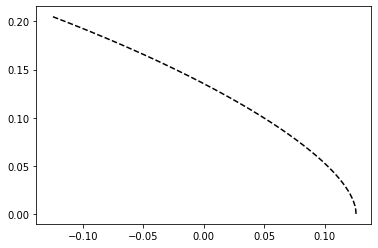

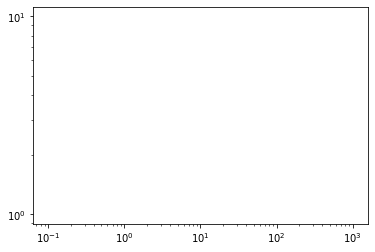

In [13]:
t = np.linspace(tm1,0,100)
plt.plot(xc[1]*xvst(t),xc[1]*vvst(t),'k-')

xint = np.arange(xc[1],-xc[1],-np.amin([xc[1]/1000.0,0.05]))
sol_dvdx = odeint(lambda v, x: 1/v*16*nb*beta*det/(1+nb*beta+4*det**2)**2*(v+alpha*x),\
                  1e-9, xint)
plt.plot(xint,sol_dvdx,'k--')

plt.figure(4)
plt.clf()
plt.loglog(xc,ve,'-',color='C0',linewidth=1.0)
plt.loglog(xc,vc,'-',color='C1',linewidth=1.0)
plt.loglog(xc,veprop*xc,'k--',linewidth=0.5)
plt.loglog(xc,vcprop*xc,'k--',linewidth=0.5)
plt.loglog(xc,-xc*vp+v0,'k-.',linewidth=0.5)
plt.loglog(xc,v0*np.ones(xc.shape),'k-',linewidth=0.25)
plt.loglog(xc,(alpha*(v0+det)/(vp+alpha) - det)*np.ones(xc.shape),'k-',linewidth=0.25)
plt.loglog(xc,1.5*xc**0.25,'b--',linewidth=0.5)
plt.ylim((0.03,100))
plt.xlabel('$r_b/(v_0^2/a_0)$')
plt.ylabel('$v_e/v_0$ or $v_c/v_0$')

Now run it vs. I/Isat

In [14]:
beta = np.logspace(-3.0,4.0,71)
#beta = np.arange(0.025,2.05,0.025)
xc = (0.0254/2)/x0Li
alpha = 0.071
det = np.arange(-6.0,-0.9,1.0)

ve = np.zeros((beta.size, det.size))
vc = np.zeros((beta.size, det.size))

vp = np.zeros(ve.shape)
v0 = np.zeros(ve.shape)

plt.figure(5)
plt.clf()
wid = [0.25,0.5,1,2]
for jj in range(det.size):
    plt.plot(np.array([-xc,xc]),-det[jj]-alpha*np.array([-xc,xc]),'--',
             color='C{0:d}'.format(jj),linewidth=0.5)
    for ii in range(beta.size):
        xint = np.arange(xc,-xc,-0.05)
        sol_dvdx = odeint(atom_motion_dx, 1e-9, xint, 
                          args=(det[jj],lambda x: beta[ii],alpha,lambda x: nb*beta[ii], nb))
        
        ve[ii,jj] = np.interp(0.0,xint[::-1],sol_dvdx[::-1].flatten())
        vc[ii,jj] = sol_dvdx[-1]

        ans1, ans2 = lcp.universaldvdxcurve(alpha,beta[ii],det[jj],nb)
        vp[ii,jj] = ans1
        v0[ii,jj] = ans2
        
        if ii%20==0:
            plt.plot(xint,sol_dvdx,'-',color='C{0:d}'.format(jj),linewidth=wid[ii/20])

plt.figure(6,figsize=(6.5,2.75))
plt.clf()
plt.subplot('121')
for ii in range (det.size):
    plt.plot(beta,ve[:,ii],'--',linewidth=1,
               color='C{0:d}'.format(ii))
    plt.plot(beta,v0[:,ii],'-.',linewidth=0.25,
               color='C{0:d}'.format(ii))
    plt.plot(beta,vc[:,ii],'-',linewidth=1,
               color='C{0:d}'.format(ii),label='$\delta = {0:.1f}$'.format(det[ii]))
    plt.plot(beta,(alpha*(v0[:,ii]+det[ii])/(vp[:,ii]+alpha) - det[ii]),
               '-.',linewidth=0.25,color='C{0:d}'.format(ii))
plt.xlim((0,5))
plt.legend()
plt.xlabel('$I/I_{sat}$')
plt.ylabel('$v_c/v_0$ or $v_e/v_0$')

plt.subplot('122')
for ii in range (det.size):
    plt.loglog(beta,ve[:,ii],'--',linewidth=1,
               color='C{0:d}'.format(ii))
    plt.loglog(beta,vc[:,ii],'-',linewidth=1,
               color='C{0:d}'.format(ii),label='$\delta = {0:.1f}$'.format(det[ii]))
plt.xlabel('$I/I_{sat}$')
plt.legend()

NameError: name 'x0Li' is not defined

Now, there are a few aspects of this that are confusing.  So let's pick 
an I/Isat and run the magnetic field gradient:

In [15]:
alpha = np.arange(0,0.2,0.0005)
beta = 1.0
xc = (0.0254/2)/x0Li
det = -5.0

ve = np.zeros(alpha.shape)
vc = np.zeros(alpha.shape)

plt.figure(8)
plt.clf()
plt.plot(np.array([-xc,xc]),-det-alpha[0]*np.array([-xc,xc]),'k-',linewidth=0.5)
plt.plot(np.array([-xc,xc]),-det-alpha[-1]*np.array([-xc,xc]),'k-',linewidth=0.5)
for jj in range(alpha.size):
    xint = np.arange(xc,-xc,-0.05)
    sol_dvdx = odeint(atom_motion_dx, 1e-9, xint,
                      args=(det,lambda x: beta,alpha[jj],lambda x: nb*beta, nb))
       
    vc[jj] = sol_dvdx[-1]
    ve[jj] = np.interp(0,xint[::-1],sol_dvdx[::-1].flatten())
    
    if (jj%5 == 10):
        plt.plot(np.array([-xc,xc]),-det-alpha[jj]*np.array([-xc,xc]),'--',
                 color='C{0:d}'.format((jj/5)%10),linewidth=0.5)
        plt.plot(xint,sol_dvdx,'-',color='C{0:d}'.format((jj/5)%10),
                 linewidth=1)


plt.figure(9)
plt.clf()
plt.plot(alpha,ve,alpha,vc)

NameError: name 'x0Li' is not defined